# Install relevant packages

In [ ]:
!pip3 install --upgrade tensorflow tensorflow-io librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa
import os
import shutil
tf.__version__

'2.15.0'

In [ ]:
tf.keras.utils.get_file("TinySOL",origin="https://zenodo.org/records/3685367/files/TinySOL.tar.gz",extract=True,cache_dir=".")
tf.keras.utils.get_file("TinySOL_metadata.csv",origin="https://zenodo.org/records/3685367/files/TinySOL_metadata.csv",cache_dir=".")

317576/317576 [==============================] - 1s 3us/step


'./datasets/TinySOL_metadata.csv'

# Load the dataset

In [ ]:
audio_dir="datasets"
ds=pd.read_csv(os.path.join(audio_dir,"TinySOL_metadata.csv"))
ds.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


In [ ]:
labels=ds["Instrument (in full)"].unique()
num_labels=len(labels)

In [ ]:
def get_mel(audio,sr):
  mel=librosa.feature.melspectrogram(y=audio,sr=sr)
  mel=librosa.power_to_db(mel,ref=np.max)

  if mel.shape[1] > 128:
    mel = mel[:, :128]
  else:
    padding = np.zeros((mel.shape[0], 128- mel.shape[1]))
    mel = np.concatenate((mel, padding), axis=1)
  mel=mel[...,np.newaxis]

  return mel

def audio_mapper(x):
  file_path=os.path.join(audio_dir,x)
  audio,sr=librosa.load(path=file_path,sr=44100)
  return get_mel(audio,sr)

In [ ]:
from sklearn.model_selection import train_test_split

x,y=ds["Path"],ds["Instrument (in full)"]
x=np.array(list(map(audio_mapper,x)))
y=np.array([np.where(labels==xi)[0][0] for xi in y])
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,
                                                 random_state=1)
x_val,x_test,y_val,y_test=train_test_split(x_val,y_val,test_size=0.5,
                                             random_state=1)

In [ ]:
input_shape=x_train[0].shape

In [ ]:
input_shape

(128, 128, 1)

# Define the Model

In [ ]:
def get_model():
  normalization_layer=tf.keras.layers.Normalization()
  normalization_layer.adapt(data=x_train)


  model=tf.keras.models.Sequential(layers=(
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(height=32,width=32),
    normalization_layer,
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=3,
                           activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=num_labels,activation=tf.keras.activations.softmax)
    ))

  model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=("acc",)
    )

  return model

In [ ]:
model=get_model()

# Define the callbacks

In [ ]:
class OverFitMonCB(tf.keras.callbacks.Callback):
    """Monitor Overfitting."""

    def on_epoch_end(self, epoch, logs):
        """Print the loss ratio."""
        print(f"\tval_loss/loss: {logs['val_loss']/logs['loss']}")


TBOARD_ROOT_LOGDIR = "artifacts/tboard/"

import time

def get_tboard_logdir():
    """Get unique logdir name for each run."""
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")

    return os.path.join(TBOARD_ROOT_LOGDIR, run_id)

In [ ]:
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="artifacts/models/", save_best_only=True)
cb_earlystop = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    restore_best_weights=True)
cb_tboard = tf.keras.callbacks.TensorBoard(log_dir=get_tboard_logdir())
callbacks = (cb_checkpoint, cb_earlystop, cb_tboard, OverFitMonCB())

In [ ]:
BATCH_SIZE=64

# Train the model

In [ ]:
history = model.fit(
   x_train,y_train,batch_size=BATCH_SIZE,
    validation_data=(x_val,y_val),
    callbacks=callbacks,
    epochs=30
)

Epoch 1/30
37/37 [==============================] - 9s 60ms/step - loss: 1.8049 - acc: 0.4288 - val_loss: 0.9418 - val_acc: 0.7423
Epoch 2/30
37/37 [==============================] - 1s 35ms/step - loss: 0.9307 - acc: 0.7013 - val_loss: 0.5024 - val_acc: 0.8351
Epoch 3/30
37/37 [==============================] - 1s 36ms/step - loss: 0.6175 - acc: 0.7987 - val_loss: 0.3501 - val_acc: 0.8935
Epoch 4/30
37/37 [==============================] - 2s 44ms/step - loss: 0.4804 - acc: 0.8399 - val_loss: 0.2668 - val_acc: 0.9175
Epoch 5/30
37/37 [==============================] - 1s 36ms/step - loss: 0.3910 - acc: 0.8708 - val_loss: 0.2315 - val_acc: 0.9244
Epoch 6/30
37/37 [==============================] - 1s 35ms/step - loss: 0.3156 - acc: 0.8897 - val_loss: 0.2143 - val_acc: 0.9107
Epoch 7/30
37/37 [==============================] - 2s 43ms/step - loss: 0.2908 - acc: 0.9021 - val_loss: 0.1827 - val_acc: 0.9381
Epoch 8/30
37/37 [==============================] - 2s 44ms/step - loss: 0.2283 - a

# Evaluate model

In [ ]:
model.evaluate(x_test,y_test)

10/10 [==============================] - 1s 42ms/step - loss: 0.0928 - acc: 0.9658


[0.09280262887477875, 0.965753436088562]

In [ ]:
def predict(x):
  x=tf.ensure_shape(x,(None,128,128,1))
  return tf.argmax(model.predict(x),axis=-1)

In [ ]:
predict(x_train[0][np.newaxis,...]),y_train[0]

1/1 [==============================] - 0s 471ms/step


(<tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>, 5)

# Create Custom Pseudo Dataset Class

In [ ]:
class GeneralDS:
  def __init__(self,metadata_csv_path,audio_dir_path):
    self.metadata_csv_path=metadata_csv_path
    self.audio_dir_path=audio_dir_path
    self.metadata=pd.read_csv(metadata_csv_path)

  def __getitem__(self,i):
    d={}
    item=self.metadata.iloc[i]
    d["file"]= os.path.basename(item["Path"])
    file_path= os.path.join(self.audio_dir_path,item["Path"])
    audio,sr=librosa.load(path=file_path,sr=44100)
    d["audio"]=audio[tf.newaxis,:]
    d["mel"]=get_mel(audio,sr)
    d["gt"]=item["Instrument (in full)"]
    d["pseudo"] = predict(d["mel"])

    return d

  def __len__(self):
      return len(self.metadata)

In [ ]:
g_ds=GeneralDS("datasets/TinySOL_metadata.csv",audio_dir)
pseudo_y_train=predict(x_train)

73/73 [==============================] - 1s 6ms/step


# Train the model on pseudo labels

In [ ]:
model_p=get_model()

In [ ]:
history_p = model_p.fit(
   x_train,pseudo_y_train,batch_size=BATCH_SIZE,
    validation_data=(x_val,y_val),
    callbacks=callbacks,
    epochs=30
)

Epoch 1/30
37/37 [==============================] - 2s 17ms/step - loss: 1.8437 - acc: 0.4172 - val_loss: 1.0633 - val_acc: 0.6873
Epoch 2/30
37/37 [==============================] - 1s 14ms/step - loss: 1.0083 - acc: 0.6747 - val_loss: 0.5616 - val_acc: 0.7973
Epoch 3/30
37/37 [==============================] - 1s 14ms/step - loss: 0.6784 - acc: 0.7781 - val_loss: 0.3555 - val_acc: 0.8660
Epoch 4/30
37/37 [==============================] - 1s 15ms/step - loss: 0.5133 - acc: 0.8275 - val_loss: 0.3015 - val_acc: 0.9210
Epoch 5/30
37/37 [==============================] - 1s 14ms/step - loss: 0.3955 - acc: 0.8704 - val_loss: 0.2369 - val_acc: 0.9278
Epoch 6/30
37/37 [==============================] - 0s 12ms/step - loss: 0.3499 - acc: 0.8794 - val_loss: 0.2094 - val_acc: 0.9278
Epoch 7/30
37/37 [==============================] - 0s 10ms/step - loss: 0.2644 - acc: 0.9120 - val_loss: 0.2283 - val_acc: 0.9278
Epoch 8/30
37/37 [==============================] - 0s 10ms/step - loss: 0.2374 - a

In [ ]:
model_p.evaluate(x_test,y_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.0827 - acc: 0.9692


[0.08267240971326828, 0.9691780805587769]

# Plot metrics

Text(0, 0.5, 'Accuracy [%]')

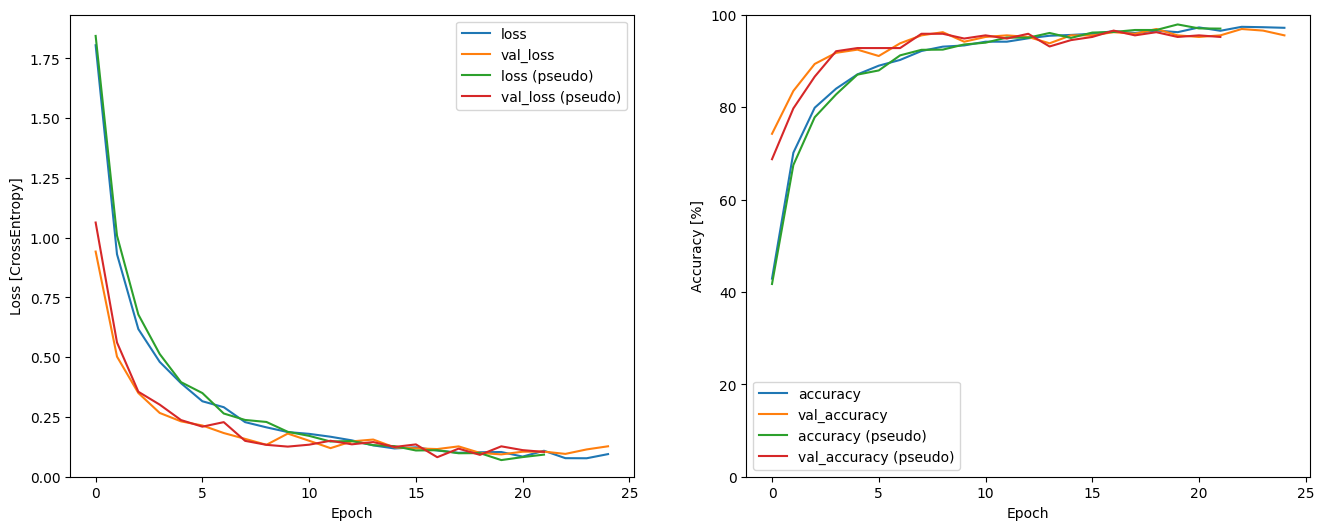

In [ ]:
metrics=history.history
metrics_p=history_p.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.plot(history_p.epoch,metrics_p["loss"],metrics_p["val_loss"])
plt.legend(["loss", "val_loss", "loss (pseudo)", "val_loss (pseudo)"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Loss [CrossEntropy]")

plt.subplot(1,2,2)
plt.plot(history.epoch,
         100*np.array(metrics["acc"]),
         100*np.array(metrics["val_acc"]))
plt.plot(history_p.epoch,
         100*np.array(metrics_p["acc"]),
         100*np.array(metrics_p["val_acc"]))
plt.legend(["accuracy", "val_accuracy", "accuracy (pseudo)", "val_accuracy (pseudo)"])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

In [ ]:
src_dir="datasets"
ds_dir="dset"
for f_name in os.listdir(src_dir):
  fam_path=os.path.join(src_dir,f_name)
  if not os.path.isdir(fam_path):
     continue
  for class_name in os.listdir(fam_path):
    shutil.copytree(os.path.join(fam_path,class_name,"ordinario"),os.path.join("dset",class_name))

In [ ]:
train_ds , val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=ds_dir,
    #output_sequence_length=,
    batch_size=32,
    seed=0,
    validation_split=0.2,
    subset="both"
    )

num_labels=len(train_ds.class_names)

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

val_ds = val_ds.shard(num_shards=2, index=0)
test_ds = val_ds.shard(num_shards=2, index=1)

Found 2913 files belonging to 14 classes.
Using 2331 files for training.
Using 582 files for validation.


In [ ]:
def get_spectrogram(x):
  spectrogram=tf.abs(tf.signal.stft(x,frame_length=255,frame_step=128))
  return spectrogram[...,tf.newaxis]

def make_spectrogram_ds(ds):
  return ds.map(
      map_func=lambda x,y: (get_spectrogram(x), y),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spectrogram_ds(train_ds)
val_spectrogram_ds = make_spectrogram_ds(val_ds)
test_spectrogram_ds = make_spectrogram_ds(test_ds)

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
general_ds=tf.data.experimental.make_csv_dataset(
    file_pattern=os.path.join("datasets","TinySOL_metadata.csv"),
    batch_size=1,
    label_name="Instrument (in full)",
    num_epochs=1
    )

#general_ds=tf.data.Dataset.from_tensor_slices(dict(ds))

def deconstruct(x,l):
  return x["Path"],l


@tf.py_function(Tout=[tf.float32,tf.int32])
def audio_mapper(item,l):
  file_path=os.path.join(audio_dir,item.numpy()[0].decode("utf-8"))
  audio,sr=librosa.load(path=file_path,sr=44100)
  mel=librosa.feature.melspectrogram(y=audio,sr=sr)
  mel=librosa.power_to_db(mel,ref=np.max)

  if mel.shape[1] > 128:
    mel = mel[:, :128]
  else:
    padding = np.zeros((mel.shape[0], 128- mel.shape[1]))
    mel = np.concatenate((mel, padding), axis=1)
  mel=np.expand_dims(mel,axis=-1)
  return mel,np.where(labels==l.numpy()[0].decode("utf-8"))

general_ds=general_ds.map(deconstruct)
general_ds=general_ds.map(audio_mapper)
general_ds=general_ds.batch(32)

[x for x in general_ds.take(1)]

In [ ]:
input_shape=[x[0].shape for x in train_spectrogram_ds.take(1)][0][1:]

In [ ]:
input_shape=[x[0].shape for x in general_ds.take(1)][0][1:]

In [ ]:
model.evaluate(test_spectrogram_ds)

5/5 [==============================] - 7s 1s/step - loss: 0.7542 - acc: 0.7761


[0.7541658878326416, 0.7761194109916687]

In [ ]:
g_ds=GeneralDS("datasets/TinySOL_metadata.csv",audio_dir)
g_ds=tf.data.Dataset.from_tensor_slices(g_ds)